In [88]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [89]:
(x_train,y_train) ,(x_test, y_test) = tf.keras.datasets.cifar100.load_data()
num_classes = 100

In [90]:
x_train.shape , y_train.shape

((50000, 32, 32, 3), (50000, 1))

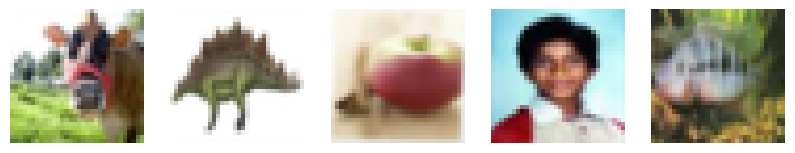

In [91]:
#데이터 확인
plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_train[i])
    plt.axis('off')
plt.show()

In [92]:
x_train = x_train /255.
x_test = x_test /255.

In [93]:
# 하이퍼 파라미터 설정

input_shape = (32,32,3)
batch_size = 32

image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2

#최신 논문일경우 러닝메이트가 쓰이는경우가 많다
learning_rate = 1e-3
weight_decay = 1e-4

epochs = 30

transformer_layers = 4
projection_dim = 64 # embedding을 통과하고 나온 wk wq wv(output_dim)이다
num_heads = 4
transformer_units = [projection_dim * 2 , projection_dim]
mlp_head_units = [2048,1024]

In [94]:
#토큰화
class PatchTokenization(layers.Layer):
    def __init__(self, image_size=image_size, patch_size=patch_size,
                 num_patches=num_patches, projection_dim=projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patch = layers.Reshape((num_patches,-1))
        self.projection = layers.Dense(projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=1e-6)
    def call(self, images):
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size,1],
            strides = [1, self.patch_size, self.patch_size,1],
            rates = [1,1,1,1],
            padding="VALID"
        )
        flat_patches = self.flatten_patch(patches)
        tokens = self.projection(flat_patches)
        return (tokens, patches)

In [95]:
#크기가 너무 작아서 재조정
image = x_train[4]
resized = tf.image.resize(tf.convert_to_tensor([image]),size=(image_size,image_size))
resized.shape

TensorShape([1, 72, 72, 3])

In [96]:
(token, patch) = PatchTokenization()(resized)
print(token.shape)
print(patch.shape)

(1, 144, 64)
(1, 12, 12, 108)


In [97]:
(token,patch) = (token[0],patch[0])

n = patch.shape[0]
count = 1

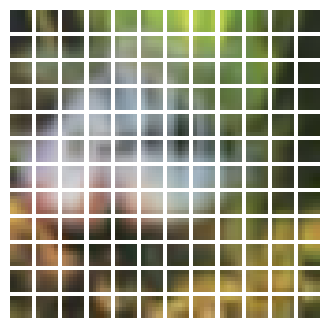

In [98]:
#패치화 확인 시각화
plt.figure(figsize=(4,4))
for row in range(n):
    for col in range(n):
        plt.subplot(n,n,count)
        count += 1
        image = tf.reshape(patch[row][col], (patch_size, patch_size, 3))
        plt.imshow(image)
        plt.axis('off')
plt.show()

In [99]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches=num_patches,
                 projection_dim=projection_dim , **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.poisition_embedding = layers.Embedding(input_dim = num_patches, output_dim = projection_dim)
        self.positions = tf.range(start=0, limit=self.num_patches,delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.poisition_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches


In [100]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation = tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [101]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    x = layers.Normalization()(inputs)
    x = layers.Resizing(image_size,image_size)(x)
    (tokens , _ )= PatchTokenization()(x)
    encoded_patches = PatchEncoder()(tokens)
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches) ##
        attention_output = layers.MultiHeadAttention(num_heads=num_heads,
                                                     key_dim=projection_dim,
                                                     dropout=0.1)(x1,x1)
        x2 = layers.Add()([attention_output,encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2) #
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3,x2])

    x = layers.LayerNormalization(epsilon=1e-6)(encoded_patches) #
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = mlp(x, hidden_units=mlp_head_units, dropout_rate=0.5)
    outputs = layers.Dense(num_classes)(x)
    model = tf.keras.Model(inputs=inputs , outputs=outputs)
    return model

In [102]:
vit = create_vit_classifier()
vit.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 normalization_12 (Normaliz  (None, 32, 32, 3)            7         ['input_9[0][0]']             
 ation)                                                                                           
                                                                                                  
 resizing_8 (Resizing)       (None, 72, 72, 3)            0         ['normalization_12[0][0]']    
                                                                                                  
 patch_tokenization_14 (Pat  ((None, 144, 64),            6976      ['resizing_8[0][0]']    

In [103]:
class CosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps):
        super().__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("total_steps 값이 warmup_steps보다 크거나 같아야합니다.")

        cos_annealed_lr = tf.cos(self.pi * (tf.cast(step, tf.float32) - self.warmup_steps) / float(self.total_steps - self.warmup_steps))
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "learning_rate_base 값이 warmup_learning_rate보다 크거나 같아야합니다.")
            slope = (self.learning_rate_base - self.warmup_learning_rate) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(step < self.warmup_steps, warmup_rate, learning_rate)
        return tf.where(step > self.total_steps, 0.0, learning_rate, name="learning_rate")



In [104]:
total_steps = int((len(x_train) / batch_size) * epochs)
warmup_epoch_percentage = 0.10
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = CosineDecay(
    learning_rate_base=learning_rate,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,)

In [105]:
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=scheduled_lrs,
    weight_decay=weight_decay)

In [106]:
vit.compile(optimizer=optimizer,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

In [107]:
history = vit.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10)

Epoch 1/10
1563/1563 [==============================] - 84s 44ms/step - loss: 4.7737 - accuracy: 0.0164 - val_loss: 4.3434 - val_accuracy: 0.0331
Epoch 2/10
1563/1563 [==============================] - 67s 43ms/step - loss: 4.3795 - accuracy: 0.0319 - val_loss: 4.2031 - val_accuracy: 0.0522
Epoch 3/10
1563/1563 [==============================] - 67s 43ms/step - loss: 4.1138 - accuracy: 0.0600 - val_loss: 3.6915 - val_accuracy: 0.1272
Epoch 4/10
1563/1563 [==============================] - 68s 43ms/step - loss: 3.6003 - accuracy: 0.1378 - val_loss: 3.2925 - val_accuracy: 0.1984
Epoch 5/10
1563/1563 [==============================] - 66s 42ms/step - loss: 3.2926 - accuracy: 0.1965 - val_loss: 3.0358 - val_accuracy: 0.2439
Epoch 6/10
1563/1563 [==============================] - 69s 44ms/step - loss: 3.1110 - accuracy: 0.2309 - val_loss: 2.9425 - val_accuracy: 0.2637
Epoch 7/10
1563/1563 [==============================] - 69s 44ms/step - loss: 2.9615 - accuracy: 0.2599 - val_loss: 2.8048 -

In [108]:
#시각화는 추후